# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import pysal as ps
import seaborn as sns
import shapely

import statsmodels.api as sm
import matplotlib.pylab as plt

from geopandas import GeoDataFrame
from pandas import DataFrame
from fiona.crs import from_epsg
from matplotlib import colors
%matplotlib inline

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('Total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

Total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

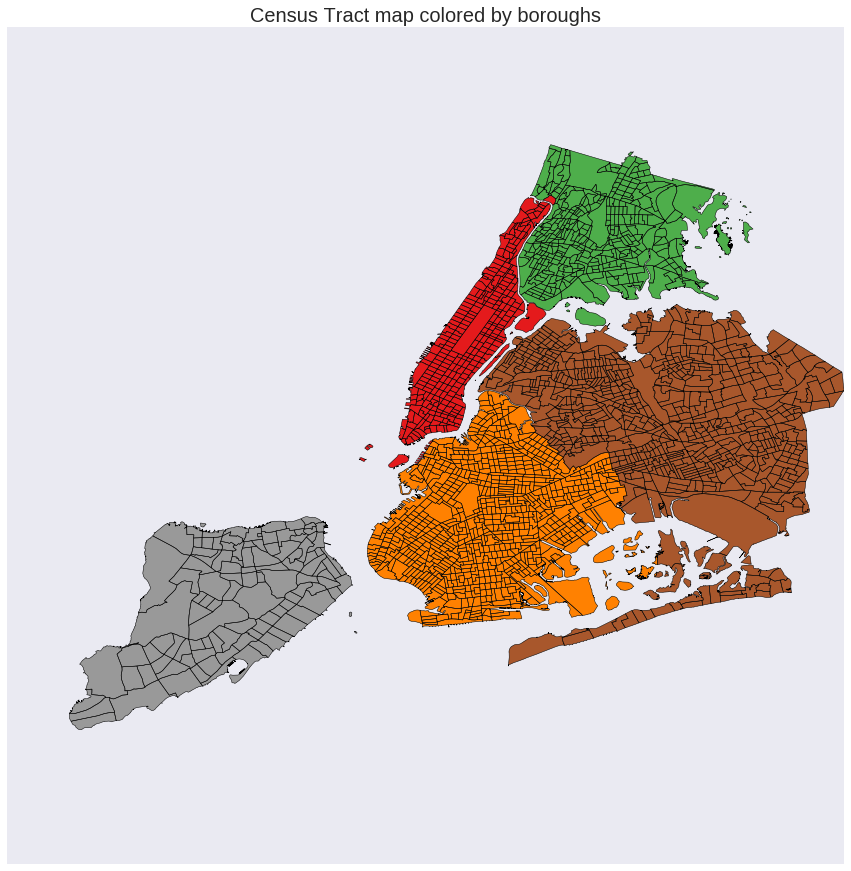

In [5]:
f, ax = plt.subplots(figsize=(15, 15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column = 'BoroCode', alpha = 1, linewidth = 0.5, ax = ax)
plt.title("Census Tract map colored by boroughs", size = 20)

**Figure 1:** Map of Census Track of New York City colorored by boroughs.

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Visualize the Population density for 2010

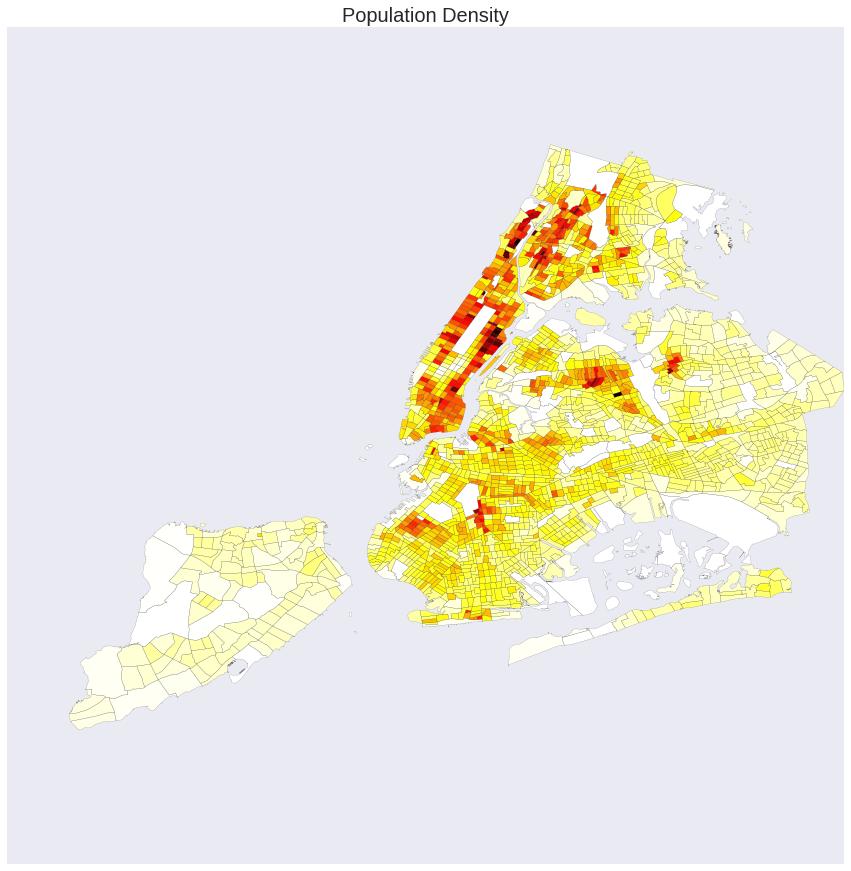

In [8]:
f, ax = plt.subplots(figsize=(15, 15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density", size = 20)

** Figure 2: Map of population density.** The map shows the density of population in New York City. It can be seen that the area which are more dense are in in Manhattan. The area of the Upper East Side and some areas of the Bronx. Contrarly, Staten Island is the area with less density.

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
bike_monthly = df_bike_monthly.copy()
bike_monthly.head(2)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# This is to create a column only with month to divide the set.

months = []
for i in bike_monthly.index:
    months.append(i.month)
bike_monthly['month'] = months

In [11]:
# summer is contains July, August, September. 
# Oficially, summer starts on 21th June, reason why I decide not to include it and keep September.  

summer_bike_monthly = bike_monthly[(bike_monthly.month>6)&(bike_monthly.month<10)]

In [12]:
summer_bike_monthly

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,month
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,7
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,8
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,9
2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,2268,...,0,0,0,0,0,0,0,0,0,7
2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,2168,...,0,0,0,0,0,0,0,0,0,8
2014-09-30,2281,3678,10357,3680,7740,3695,2217,4112,3504,2315,...,0,0,0,0,0,0,0,0,0,9
2015-07-31,2556,3831,10341,3958,6424,5397,2185,5688,4846,2743,...,0,0,0,0,0,0,0,0,0,7
2015-08-31,2640,3799,11801,4288,7031,5417,2470,6306,4583,2838,...,0,0,0,0,0,0,0,0,0,8
2015-09-30,3115,4161,11291,4357,7282,6293,2648,6477,5061,2993,...,0,0,0,0,0,0,0,0,0,9


In [13]:
# winter contains January, February and March. 
# Oficially, winter starts on 20th December, I don't think I am loosing so many rides.

winter_bike_monthly = bike_monthly[(bike_monthly.month <4)]
#winter_bike2 = bike_monthly[(bike_monthly.month >10)]
#winter_bike_monthly = winter_bike1.append(winter_bike2)

In [14]:
winter_bike_monthly

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1534,1535,1536,1537,1538,1539,1540,1541,1542,month
starttime,,,,,,,,,,,,,,,,,,,,,
2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,681,...,0,0,0,0,0,0,0,0,0,1
2014-02-28,650,960,2920,676,1808,933,508,1045,963,530,...,0,0,0,0,0,0,0,0,0,2
2014-03-31,804,1559,5102,1441,2643,1477,849,2004,2105,880,...,0,0,0,0,0,0,0,0,0,3
2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,619,...,0,0,0,0,0,0,0,0,0,1
2015-02-28,562,0,2130,913,1363,1140,356,1023,891,447,...,0,0,0,0,0,0,0,0,0,2
2015-03-31,1012,0,3574,1401,2201,2047,617,1867,1505,769,...,0,0,0,0,0,0,0,0,0,3
2016-01-31,1031,1669,4533,1847,2304,1943,656,2485,0,935,...,0,0,0,0,0,0,0,0,0,1
2016-02-29,1200,1951,4913,2088,2503,2224,859,2814,0,1082,...,0,0,0,0,0,0,0,0,0,2
2016-03-31,1891,3181,7721,2529,4586,3692,1633,4015,0,1894,...,0,0,0,0,0,0,0,0,0,3


### Time Series Analysis - Summer

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


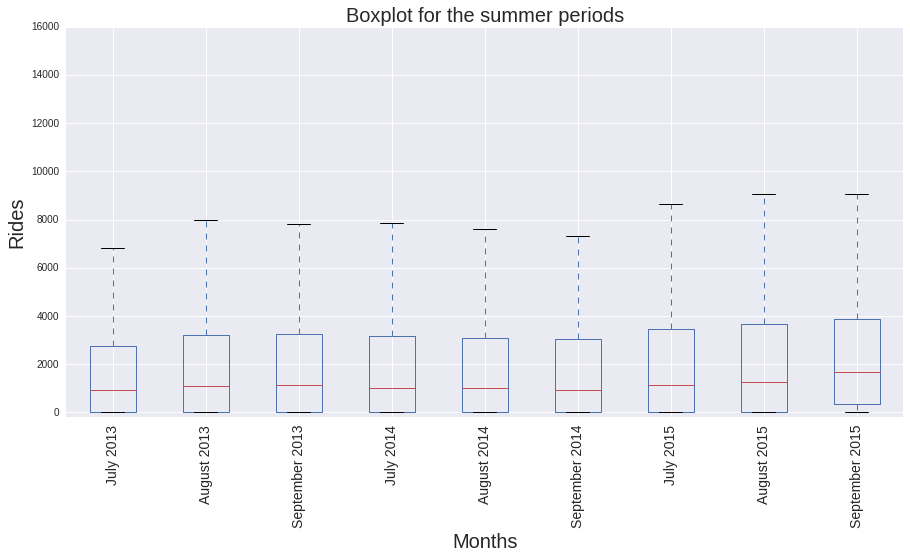

In [15]:
plt.rcParams['font.size'] = 14
f, ax = plt.subplots(figsize = (15,7))
#create a copy of the df for the viz purposes
summer_bike_monthly_ = summer_bike_monthly.copy()
summer_bike_monthly_.index = summer_bike_monthly_.index.strftime("%B %Y")
summer_bike_monthly_.T.boxplot(figsize = (15,7), ax = ax, rot = 90)

ax.set_ylim([-200,16000])
ax.set_title('Boxplot for the summer periods', size = 20)
ax.set_ylabel('Rides', size = 20)
ax.set_xlabel('Months', size = 20)
plt.show()

**Figure 3: Boxplot of the rides corresponding to the months of summer from 2013 until 2015**. It can be seen that the distribution of the rides from moth to month doesn't varies as much as it has a constant mean. It is interesting to see how usually at the end of the summer there are less rides except in 2015 that there is an increase.

In [16]:
### Time Series Analysis - Winter

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


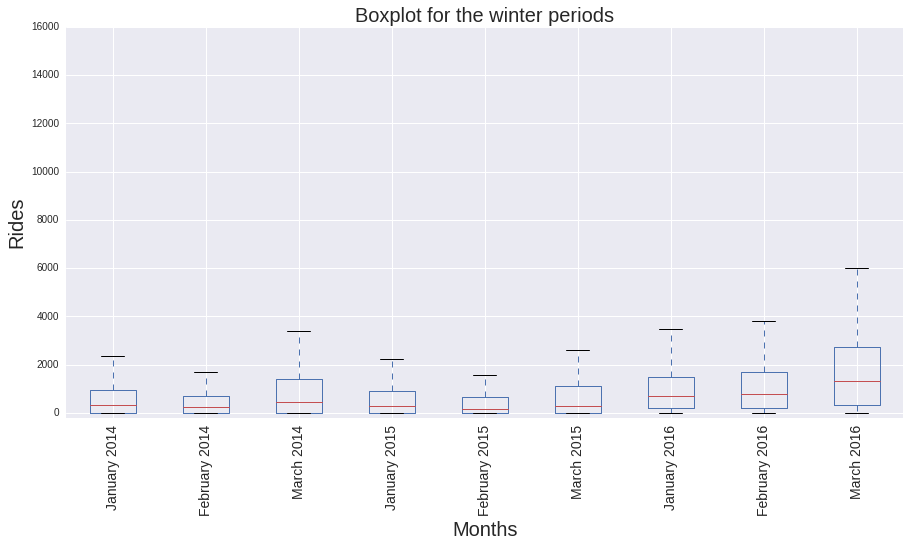

In [17]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(15, 7))
#create a copy of the df for the viz purposes
winter_bike_monthly_ = winter_bike_monthly.copy()
winter_bike_monthly_.index = winter_bike_monthly_.index.strftime("%B %Y")
winter_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
                     
ax.set_title('Boxplot for the winter periods', size = 20)
ax.set_ylabel('Rides', size = 20)
ax.set_xlabel('Months', size = 20)
plt.show()

**Figure 4: Boxplot of the rides corresponding to the months of winter from 2013 until 2015**. It can be seen that the distribution of the rides from moth to month doesn't varies as much and that March the beginning of the spring there are more rides. 

#### Seasonal Decomposition

In [18]:
#Create a monthly time series of bike ride (Average of all citibike stations)
#df_new = bike_monthly_.mean(1).resample('M').mean()
#df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
#res = sm.tsa.seasonal_decompose(df_new.dropna())
#plt.rcParams['figure.figsize']=(12,8)
#resplot = res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [19]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Coordinates (Lat & Lon)

In [20]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [ ]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010'] = a

In [22]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [23]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()

In [25]:
# summer

In [26]:
summer_station_id = station_id.copy()

In [27]:
summer_station_id['MonthlyAve'] = summer_bike_monthly_.sum()

In [28]:
summer_station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,22940
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,35290
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,89624
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,33287
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,62215


In [29]:
# winter

In [30]:
winter_station_id = station_id.copy()

In [31]:
winter_station_id['MonthlyAve'] = winter_bike_monthly_.sum()

In [32]:
winter_station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,8939
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,10657
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,37257
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,13394
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,21320


### Add the monthly average rides to the CT shapefile 

In [35]:
# Summer

In [36]:
temp_summer = summer_station_id[['MonthlyAve']]
temp_summer['station_id'] = summer_station_id.index
temp_summer.index = summer_station_id['BoroCT2010']
ct_shape_MonthlyAve_summer = ct_shape.join(temp_summer)
ct_shape_MonthlyAve_summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


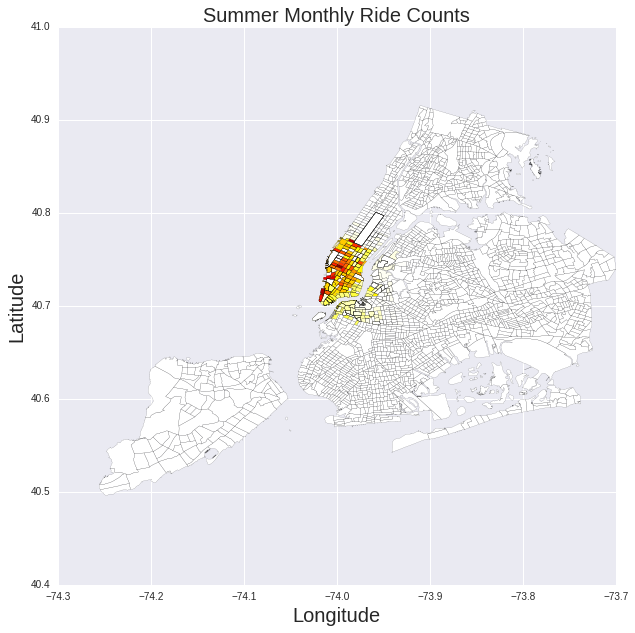

In [135]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_summer.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts", size = 20)

ax.set_ylabel('Latitude', size = 20)
ax.set_xlabel('Longitude', size = 20)
plt.show()

**Figure 5: Map that shows the Average Monthly rides during the summer period.** This maps is a colorheat map that shows the average of the monthly rides during the summer period. It can be seen that the area where people rides is Manhattan and a small part in Brooklyn. Of course , it is because there are no stations in other places.

In [38]:
# Winter

In [39]:
temp_winter = winter_station_id[['MonthlyAve']]
temp_winter['station_id'] = winter_station_id.index
temp_winter.index = winter_station_id['BoroCT2010']
ct_shape_MonthlyAve_winter = ct_shape.join(temp_winter)
ct_shape_MonthlyAve_winter.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


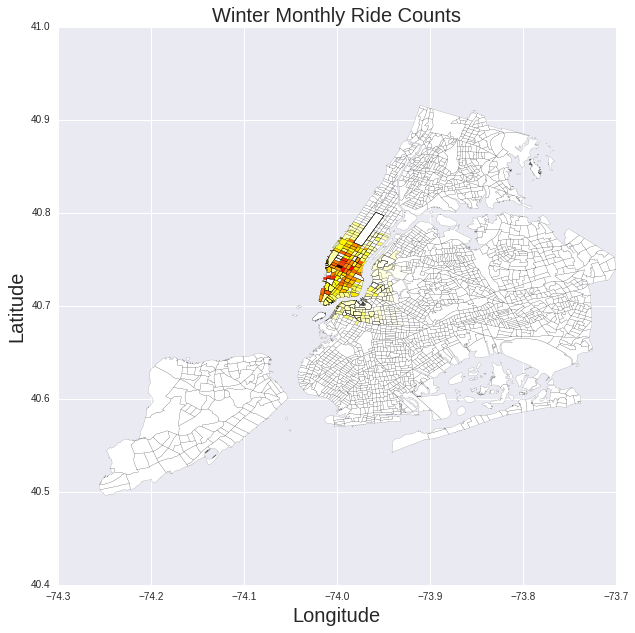

In [136]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_winter.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts", size = 20)

ax.set_ylabel('Latitude', size = 20)
ax.set_xlabel('Longitude', size = 20)
plt.show()

**Figure 6: Map that shows the Average Monthly rides during the winter period.** This maps is a colorheat map that shows the average of the monthly rides during the winter period. It can be seen that the area where people rides is Manhattan and a small part in Brooklyn. Of course , it is because there are no stations in other places.

### Removing the CTs that are out of zoom boundries

In [41]:
# Summer

In [42]:
ct_shape_MonthlyAve_summer_Zoom = (ct_shape_MonthlyAve_summer[ct_shape_MonthlyAve_summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [43]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp_summer.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


In [44]:
# Winter

In [45]:
ct_shape_MonthlyAve_winter_Zoom = (ct_shape_MonthlyAve_winter[ct_shape_MonthlyAve_winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [46]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp_winter.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

In [47]:
#Summer

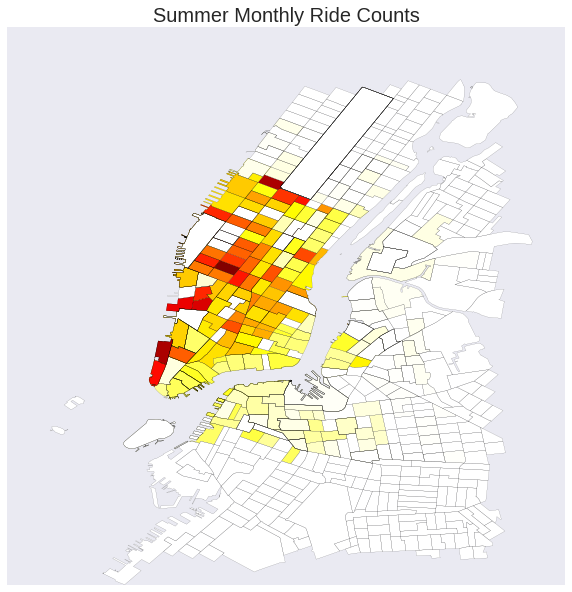

In [139]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_summer_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Monthly Ride Counts", size = 20)
plt.show()

**Figure 7: Map that shows the Average Monthly rides during the summer period.** This maps is a zoom in into the area of the rides of the Figure 5. As well, it is a colorheat map that shows the average of the monthly rides during the summer period. It can be seen that the area where people rides is Manhattan and a small part in Brooklyn. Of course , it is because there are no station in other places. It can be seen that it is popular the area of lower Manhattan and Midtown and some areas nearby Central Park. 

In [49]:
## Winter

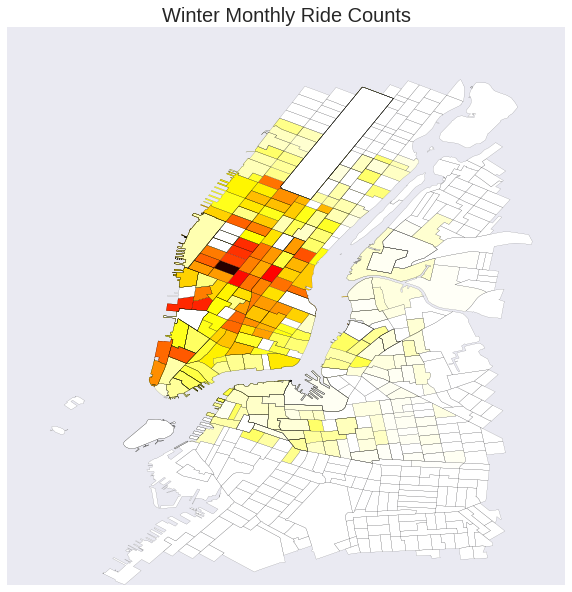

In [141]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_winter_Zoom.plot(column='MonthlyAve',cmap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Monthly Ride Counts", size = 20)
plt.show()

**Figure 8: Map that shows the Average Monthly rides during the winter period.** This maps is a zoom in into the area of the rides of the Figure 6. As well, it is a colorheat map that shows the average of the monthly rides during the winter period. It can be seen that the area where people rides is Manhattan and a small part in Brooklyn. Of course , it is because there are no stations in other places. It can be seen that it is popular the area of lower Manhattan and Midtown. In comparison to summer rides, it is significant that the area of the uppers appears.

### Export Shapefile CTs in the CitiBike Zone

In [51]:
# Summer and Winter

In [142]:
path_summer = 'Output/ct_shape_MonthlyAve_summer_Zoom.shp'
ct_shape_MonthlyAve_summer_Zoom.to_file(path_summer)

In [143]:
path_winter = 'Output/ct_shape_MonthlyAve_winter_Zoom.shp'
ct_shape_MonthlyAve_winter_Zoom.to_file(path_winter)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [54]:
# Summer

In [55]:
qW_CT_summer = ps.queen_from_shapefile(path_summer)

('Island id: ', [0])


In [56]:
# winter

In [57]:
qW_CT_winter = ps.queen_from_shapefile(path_winter)

('Island id: ', [0])


#### Neighbors of index10

In [58]:
#Summer

In [59]:
qW_CT_summer[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [60]:
qW_CT_summer.cardinalities[10]

9

In [61]:
# Winter

In [62]:
qW_CT_winter[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [63]:
qW_CT_winter.cardinalities[10]

9

#### Matrix of Weights

In [64]:
# Summer

In [65]:
Wmatrix_summer, ids_summer = qW_CT_summer.full()

In [66]:
Wmatrix_summer

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [67]:
# Winter

In [68]:
Wmatrix_winter, ids_winter = qW_CT_winter.full()

In [69]:
Wmatrix_winter

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [70]:
# Summer

In [71]:
qW_CT_summer.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


In [72]:
# Winter

In [73]:
qW_CT_winter.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [74]:
# Summer

In [75]:
MonthlyRide_summer = ct_shape_MonthlyAve_summer_Zoom.MonthlyAve
MonthlyRideLag_summer = ps.lag_spatial(qW_CT_summer, MonthlyRide_summer)

In [76]:
# Winter

In [77]:
MonthlyRide_winter = ct_shape_MonthlyAve_winter_Zoom.MonthlyAve
MonthlyRideLag_winter = ps.lag_spatial(qW_CT_winter, MonthlyRide_winter)

#### Create Quantiles for maping

In [78]:
# Summer

In [79]:
MonthlyRideLagQ10_summer = ps.Quantiles(MonthlyRideLag_summer, k=10)
MonthlyRideLagQ10_summer

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               161
    0.000 < x[i] <=   696.661                78
  696.661 < x[i] <=  1803.750                80
 1803.750 < x[i] <=  4727.424                79
 4727.424 < x[i] <=  8447.733                80
 8447.733 < x[i] <= 19124.965                79
19124.965 < x[i] <= 28039.143                80
28039.143 < x[i] <= 32246.317                79
32246.317 < x[i] <= 48706.786                80

In [80]:
# Winter

In [81]:
MonthlyRideLagQ10_winter = ps.Quantiles(MonthlyRideLag_winter, k=10)
MonthlyRideLagQ10_winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    39.286                 2
   39.286 < x[i] <=   643.458                78
  643.458 < x[i] <=  1542.231                80
 1542.231 < x[i] <=  2423.257                79
 2423.257 < x[i] <=  3482.583                80
 3482.583 < x[i] <=  7797.024                79
 7797.024 < x[i] <= 10658.739                80
10658.739 < x[i] <= 12831.099                79
12831.099 < x[i] <= 20961.000                80

#### Map the monthly rides lag

In [82]:
# Summer

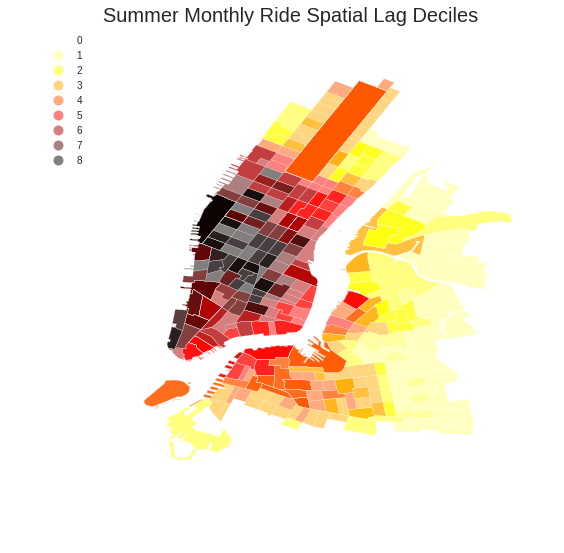

In [147]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_summer_Zoom.assign(cl=MonthlyRideLagQ10_summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles", size = 20)

**Figure 9: Map of Monthly Spatial Lag Deciles during the summer period.** It is a colorheat map that shows the average of the monthly rides during the winter period.

In [84]:
# Winter

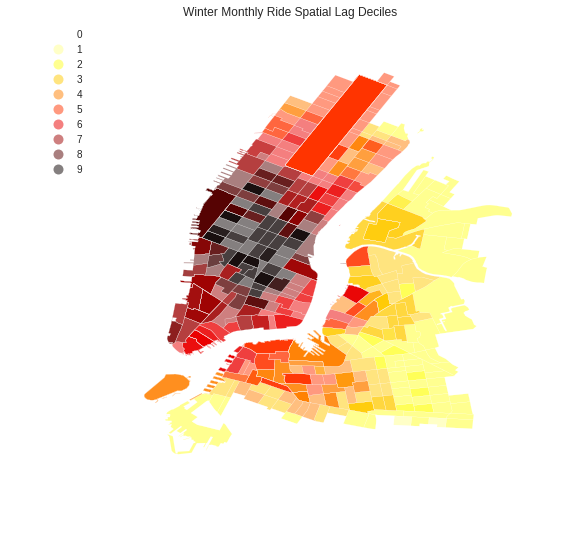

In [85]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_winter_Zoom.assign(cl=MonthlyRideLagQ10_winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles", size  = 20 )

## Global  Spatial Autocorrelation

In [86]:
# Summer

In [87]:
b,a = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b,a 

(0.62926871704725562, 4329.2935721604899)

In [88]:
# Winter

In [89]:
b,a = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
b,a 

(0.65936945695485061, 1636.8483945460082)

### Moran Scatterplot

In [90]:
# Summer

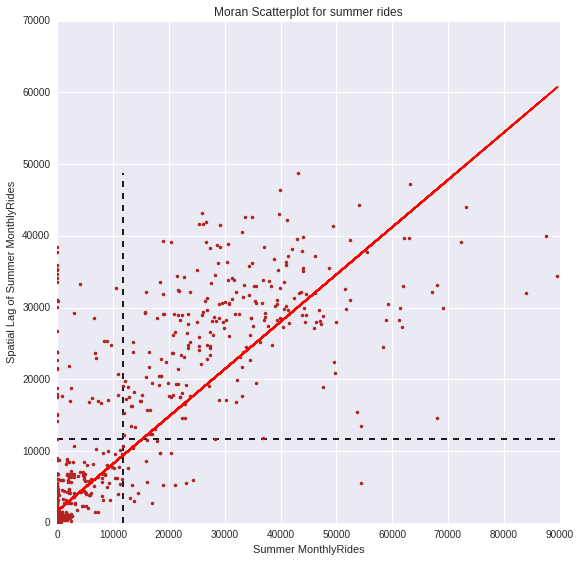

In [91]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_summer, MonthlyRideLag_summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a + b*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot for summer rides')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('Summer MonthlyRides')

In [92]:
# Winter

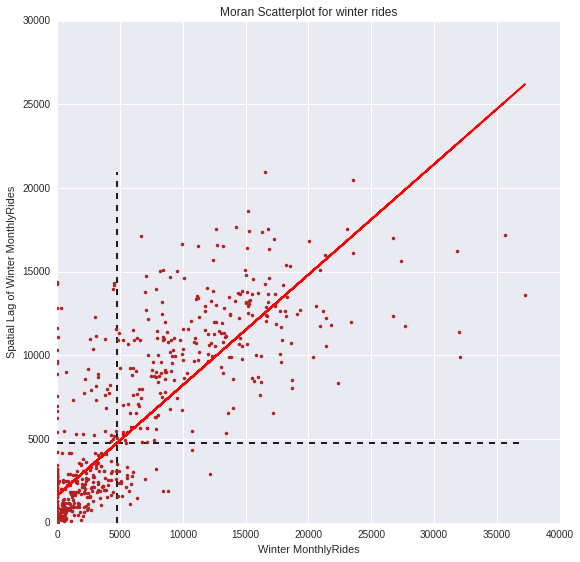

In [93]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_winter, MonthlyRideLag_winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a + b*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot for winter rides')
plt.ylabel('Spatial Lag of Winter MonthlyRides')
plt.xlabel('Winter MonthlyRides')

### Moran's I

In [94]:
# Summer

In [95]:
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT_summer)

In [96]:
I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim

(0.62946359212848402, 0.001)

In [97]:
print ('Thus, the I statistic is {:.2f} for this data, and has a very small p-value({}).'
       .format(I_MonthlyRide_summer.I,I_MonthlyRide_summer.p_sim))

Thus, the I statistic is 0.63 for this data, and has a very small p-value(0.001).


In [98]:
I_MonthlyRide_summer.sim[0:10]

array([ 0.01511933, -0.00287059,  0.0020955 ,  0.02006251,  0.00140867,
        0.01977071,  0.00515829,  0.02643785, -0.01407076,  0.00443818])

In [99]:
# Winter

In [100]:
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT_winter)

In [101]:
print ('Thus, the I statistic is {:.2f} for this data, and has a very small p-value({}).'
       .format(I_MonthlyRide_winter.I,I_MonthlyRide_winter.p_sim))

Thus, the I statistic is 0.66 for this data, and has a very small p-value(0.001).


In [102]:
I_MonthlyRide_winter.sim[0:10]

array([ 0.00319912, -0.01027433,  0.04735878,  0.01389335, -0.00613727,
       -0.01711985, -0.00470237, -0.01798315, -0.00111198, -0.00082037])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [103]:
plt.rcParams['figure.figsize']=(14,3)

In [104]:
# Summer

(-0.7, 0.7)

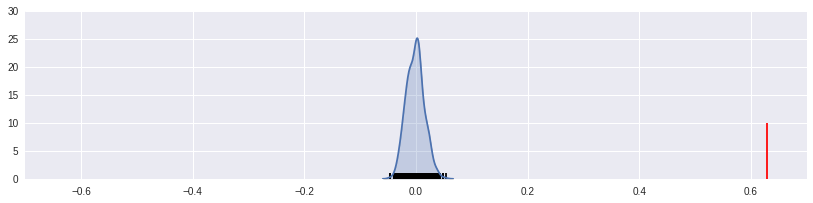

In [105]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

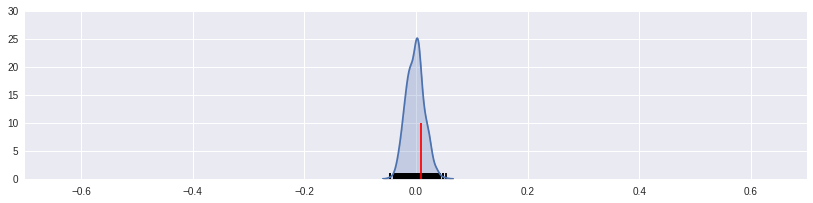

In [106]:
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

In [107]:
# Winter

(-0.7, 0.7)

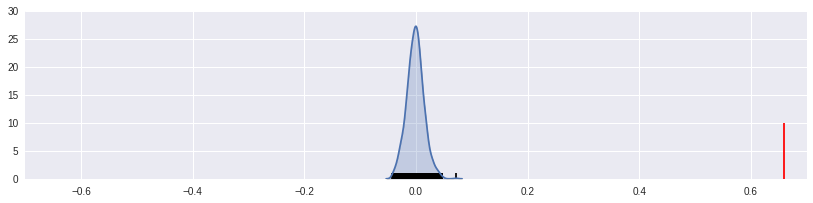

In [108]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

(-0.7, 0.7)

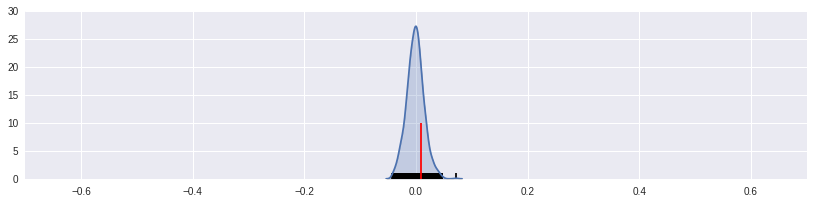

In [109]:
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [110]:
# Summer

In [111]:
LMo_MonthlyRide_summer = ps.Moran_Local(MonthlyRide_summer, qW_CT_summer,permutations=999)

In [112]:
LMo_MonthlyRide_summer.Is[0:5], LMo_MonthlyRide_summer.p_sim[0:5]

(array([-0.        , -0.23326927,  0.01313014,  0.00869015,  0.0278383 ]),
 array([ 0.001,  0.175,  0.352,  0.33 ,  0.353]))

In [113]:
# Winter

In [114]:
LMo_MonthlyRide_winter = ps.Moran_Local(MonthlyRide_winter, qW_CT_winter,permutations=999)

In [115]:
LMo_MonthlyRide_winter.Is[0:5], LMo_MonthlyRide_winter.p_sim[0:5]

(array([-0.        , -0.32301466, -0.00151236,  0.00049853, -0.05866435]),
 array([ 0.001,  0.12 ,  0.423,  0.457,  0.442]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [116]:
# summer

In [117]:
sigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim <= .001]
insigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim > .001]

In [118]:
# winter

In [119]:
sigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim <= .001]
insigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim > .001]

### Plot Signficant LISA

In [120]:
# Summer

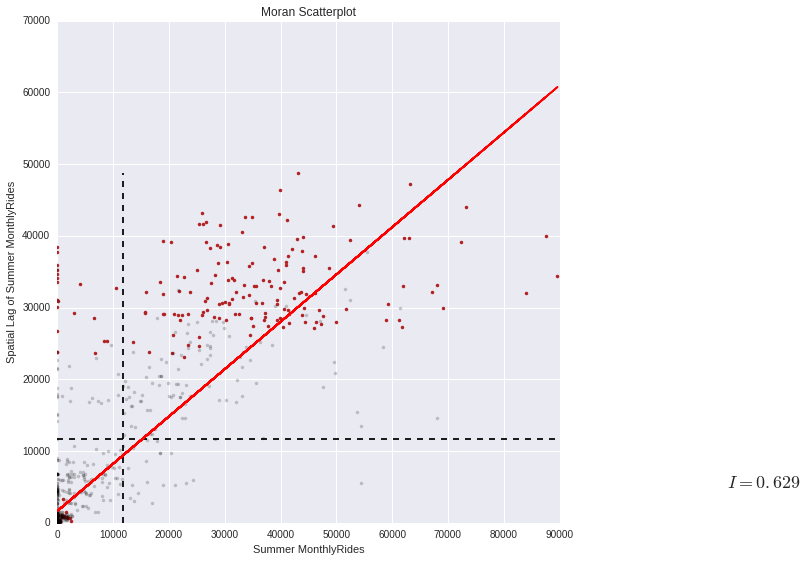

In [121]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_summer.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_summer, a + b*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer MonthlyRides')
plt.xlabel('Summer MonthlyRides')

In [122]:
# Winter

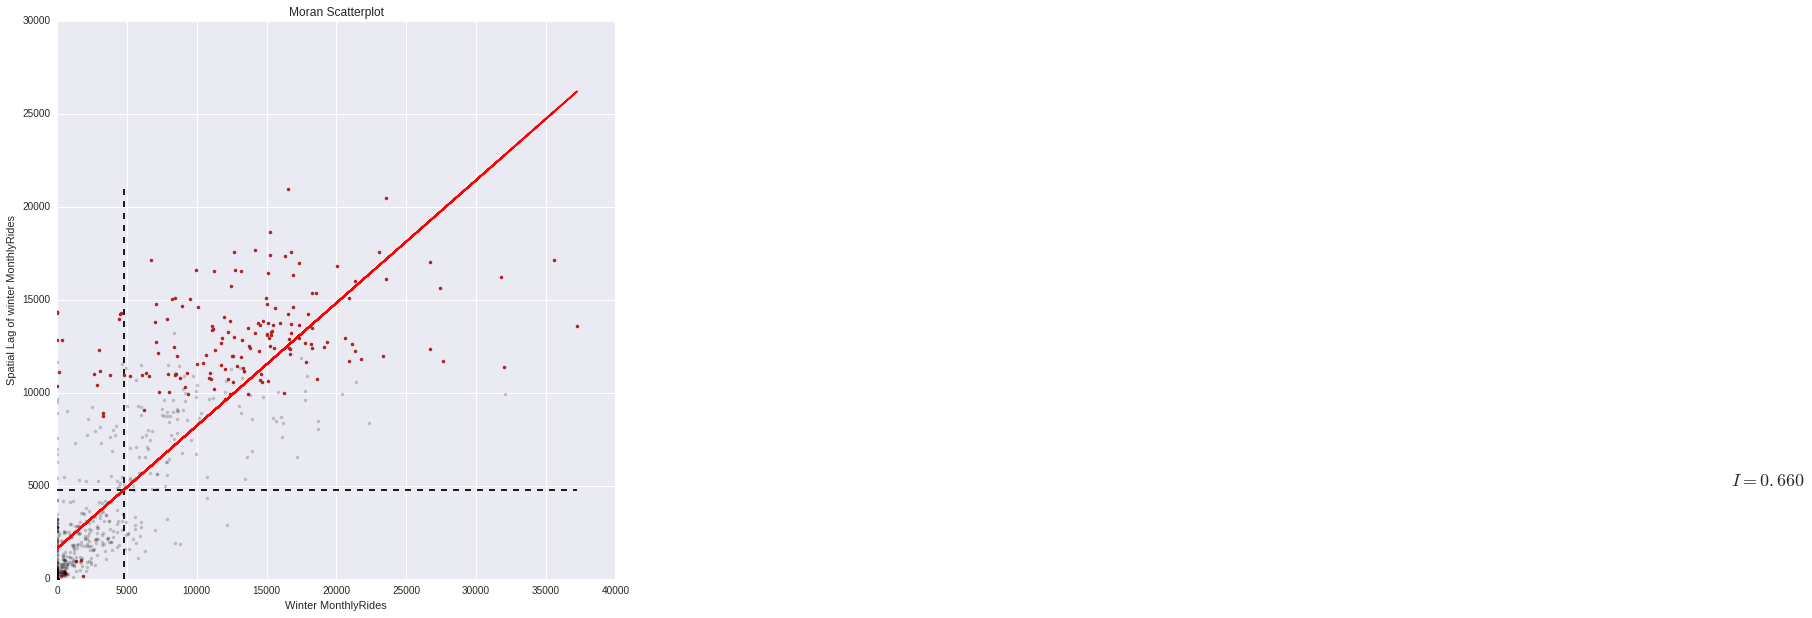

In [123]:
f, ax = plt.subplots(figsize=(10, 10))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_winter.I, x=120000, y=5000,fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_winter, a + b*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of winter MonthlyRides')
plt.xlabel('Winter MonthlyRides')

### Hot and Cold spots 

In [124]:
# Summer

In [125]:
sig_summer = LMo_MonthlyRide_summer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRide_summer.q==1 * sig_summer
coldspots_summer = LMo_MonthlyRide_summer.q==3 * sig_summer
print "Number of Hotspots:", hotspots_summer.sum()
print "Number of Coldspots:", coldspots_summer.sum()

Number of Hotspots: 189
Number of Coldspots: 209


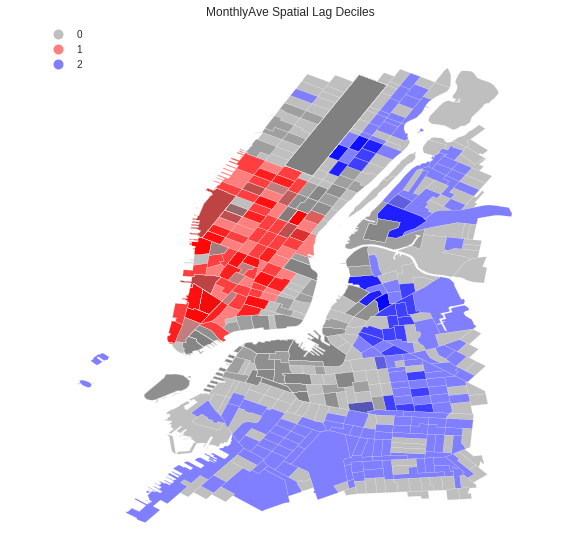

In [126]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_summer_Zoom.assign(cl=hotcold_summer).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")

In [127]:
# Winter

In [128]:
sig_winter = LMo_MonthlyRide_winter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRide_winter.q==1 * sig_winter
coldspots_winter = LMo_MonthlyRide_winter.q==3 * sig_winter
print "Number of Hotspots:", hotspots_winter.sum()
print "Number of Coldspots:", coldspots_winter.sum()

Number of Hotspots: 198
Number of Coldspots: 209


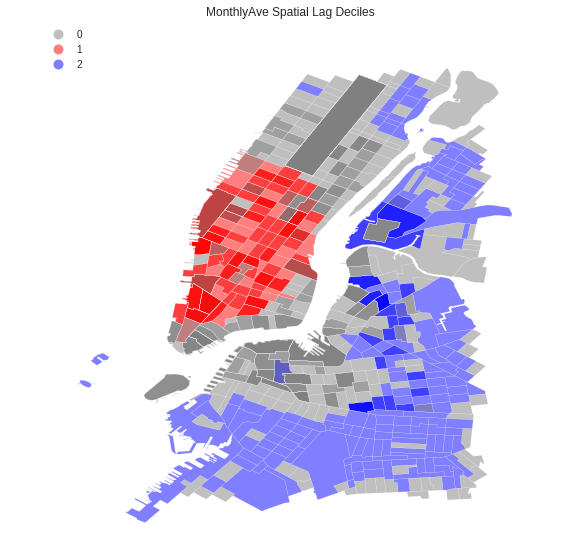

In [129]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_winter_Zoom.assign(cl=hotcold_winter).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")